In [1]:
from laspy.file import File
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data using laspy
inFile_cloud = File('../../Data/200348_pt_cloud/10552_NYU_M3 - Scanner 1 - 190511_200348_1 - originalpoints.laz', mode='r')
#inFile_fwf = File('../../Data/164239/10552_NYU_M2 - Scanner 1 - 190511_164239_1 - originalpoints.las', mode='r')
#I = inFile_cloud.Classification == 2

# raw is a 1-D numpy array, each entry is a point
raw_cloud = inFile_cloud.get_points()
#raw_fwf = inFile_fwf.get_points()
print("Number of points, point cloud: ",len(raw_cloud))
#print("Number of points, full waveform: ",len(raw_fwf))

Number of points, point cloud:  14162455


In [3]:
# Corresponds to LAS 1.4 Point Data Record Format 9
# X coordinate of the point (must be adjusted by offset and scale factor)
columns_fwf =[ 
    'X', 
    'Y',
    'Z',
    'intensity', #Intensity of the return, scaled to a 0-65,535 scale
    'flag_byte', #Return number, # of returns, Scan direction flag (+ or -), Edge of flight line flag
    'classification_flags', #Only if the point has been classified: vegetation, etc.
    'classification_byte', #Various flags about the point
    'user_data', 
    'scan_angle', # Down is 0.0, each unit is 0.006 degrees, 
    #so value between -30,000 and 30,000, or (180deg/0.006deg)
    #Spec says this incorporates the roll of the aircraft
    'pt_src_id', #Unique ID for the source of the point
    'gps_time', #GPS Week Time (seconds, reset each week) or Adj Std GPS Time
    'wave_packet_desc_index', # Indicates which waveform packet descriptor is applied.
    'byte_offset_to_waveform_data', # Locates the WF data in EVLR or .wdp file.
    'wavefm_pkt_size', # Size of the waveform packet
    'return_point_waveform_loc', # Time in picoseconds 
    'x_t', # Form parametric location: X = X_0 + x_t*t
    'y_t', # (X_0,Y_0,Z_0) is the anchor point associated with the waveform
    'z_t' ]

# Corresponds to LAS 1.4 Point Data Record Format 6
columns_point_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

In [4]:
def raw_to_df(raw,column_names):
    # function takes raw output of laspy.File.get_points() and column names, and returns a pandas Dataframe
    raw_list = [a[0].tolist() for a in raw]
    df = pd.DataFrame(raw_list,columns = column_names)
    return df

def scale_and_offset(df,header):
    '''Function takes as input the dataframe output of raw_to_df and the laspy header file.
       Output is a nx3 dataframe with adjusted X,Y, and Z coordinates, from the formula: 
       X_adj = X*X_scale + X_offset.
       Brooklyn LiDAR readings appear to be in feet, and use NAVD 88 in the vertical and 
       New York Long Island State Plane Coordinate System NAD 33 in the horizontal.'''
    offset = header.offset
    scale = header.scale
    scaled_xyz = df[['X','Y','Z']]*scale + offset
    return scaled_xyz

#INACTIVE FUNCTIONS
def split_and_strip(raw):
    '''Function takes the output ndarray of laspy File.get_points(), 
        splits each point on commas, 
        outputs a list of lists.'''
    output_list = []
    for row in raw:
        stripped = [a.strip("( , )") for a in str(row).split(',')]
        output_list.append(stripped)
    return output_list

def row_clean(string_list):
    '''Function takes as input a list of lists, the output of split_and_strip().  Cleans the entries for spaces,
    returns a numpy array where each row is a point.'''
    output_list = []
    for row in string_list:        
        output_list.append(list(map(float,row[:-1])))
    output_arr = np.array(output_list)
    return output_arr


In [5]:
# Create dataframes for point cloud and fwf
df_cloud = raw_to_df(raw_cloud,columns_point_cloud)
#df_fwf = raw_to_df(raw_fwf,columns_fwf)

# Generate adjusted coordinates for point cloud.  FWF is identical.
scaled_xyz = scale_and_offset(df_cloud,inFile_cloud.header)

In [7]:
# Total square footage:
x_range = scaled_xyz['X'].max() - scaled_xyz['X'].min()
y_range = scaled_xyz['Y'].max() - scaled_xyz['Y'].min()
z_range = scaled_xyz['Z'].max() - scaled_xyz['Z'].min()
print(" X range: {:.2f} feet\n Y range: {:.2f} feet\n Z range: {:.2f} feet".format(x_range,y_range,z_range))

 X range: 4260.41 feet
 Y range: 3457.00 feet
 Z range: 955.38 feet


In [12]:
# Time range
print("max time: ",df_cloud['gps_time'].max())
print("min time: ",df_cloud['gps_time'].min())
print("time range (seconds): ",time_range)

max time:  72306.525254983
min time:  72249.06632943501
time range (seconds):  57.45892554799502


In [6]:
df_cloud['x_scaled'] = scaled_xyz['X']
df_cloud['y_scaled'] = scaled_xyz['Y']
df_cloud['z_scaled'] = scaled_xyz['Z']

In [14]:
df_cloud.to_pickle("200348_points.pkl")

In [11]:
header_200348 = inFile_cloud.header.point_return_count

[12726202, 1048648, 282121, 82279, 19190, 3452, 500, 54, 7, 2, 0, 0, 0, 0, 0]

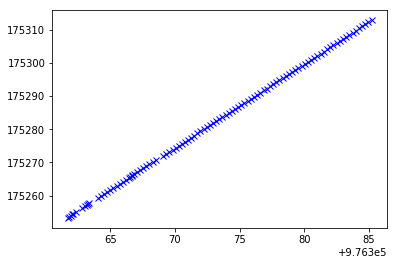

In [18]:
plt.plot(df_cloud['x_scaled'][:100],df_cloud['y_scaled'][:100],'xb')

In [19]:
from mpl_toolkits import mplot3d

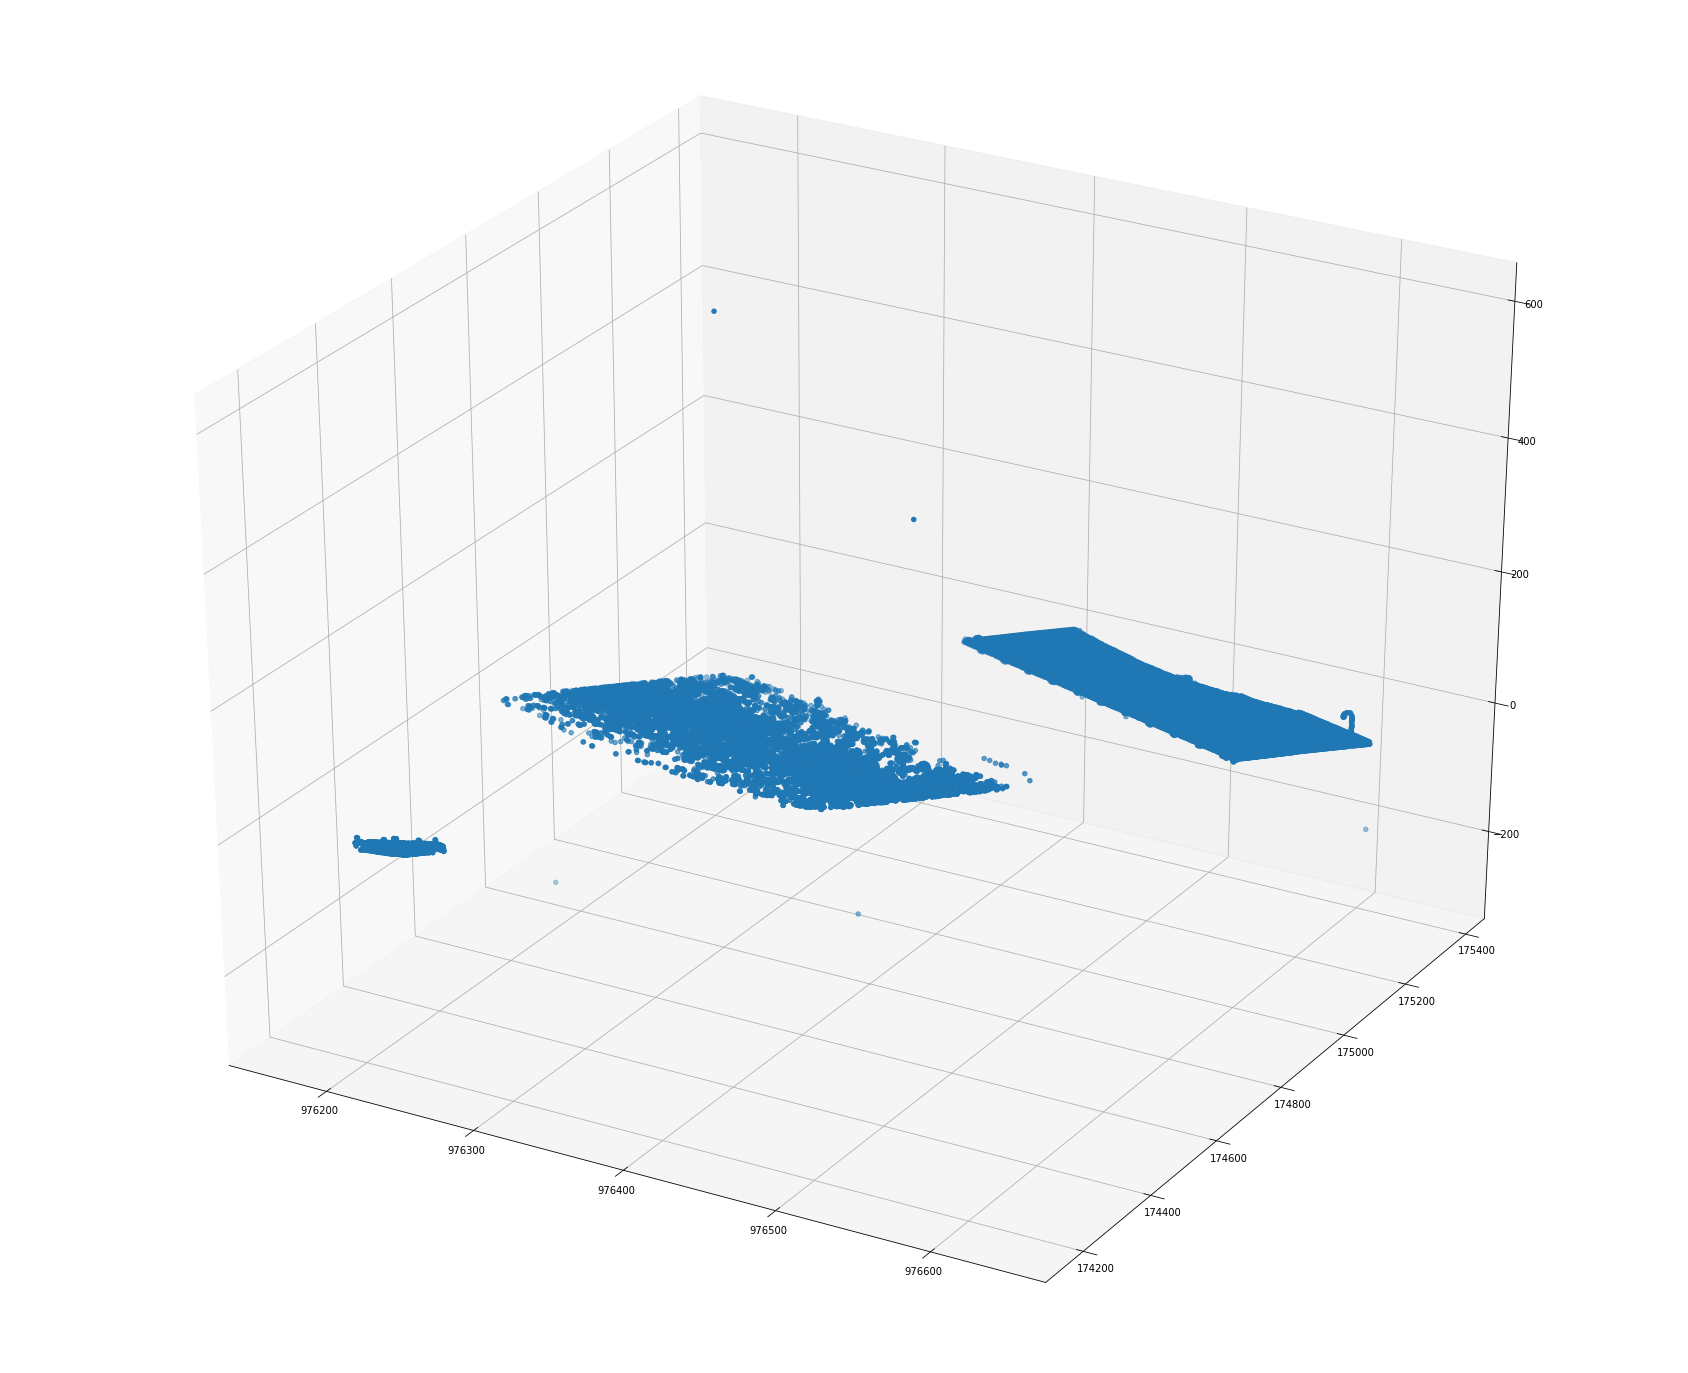

In [58]:
plt.figure(figsize=(30,25))
ax = plt.axes(projection='3d')

pt_count = 100000
ax.scatter3D(df_cloud['x_scaled'][:pt_count], 
              df_cloud['y_scaled'][:pt_count], 
              df_cloud['z_scaled'][:pt_count] , 
              cmap='Greens')